<a href="https://colab.research.google.com/github/hank199599/data_science_from_scratch_reading_log/blob/main/Chapter7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 統計假設檢定

* ## 零假設(H₀,null hypothesis)：表達我們預設的立場
* ## 替代假設(H₁,alternative hypothesis)：與預設立場對比的立場



### 範例：擲硬幣測試
假設我們想知道一枚硬幣是否是公正的，假設正面朝上的機率是p：
* 零假設(H₀)：認為硬幣是公正的，即p=0.5 
* 替代假設(H₁)：認為硬幣是不公正的，即p≠0.5 
  
**檢定方法**：  
丟擲硬幣N次，然後計算正面朝上的次數。
而每一次丟擲硬幣都代表一次伯努利測試，則X是一個二項式隨機變數Binomial(n,p)。  
因此可以用常態分佈來當作近似結果。  

In [10]:
from typing import Tuple
import math

def normal_approximation_to_binomial(n:int,p:float) -> Tuple[float,float]:
  #送回Binominal(n,p)對應的平均值mu和標準差sigma
  mu = n*p
  sigma = math.sqrt(p*(1-p)*n)
  return mu,sigma

只要隨機變數確實依循常態分佈，我們就可以用normal_cdf算出其值落在特定區間內(或之外)的機率

In [11]:
import math
SQRT_TWO_PI = math.sqrt(2* math.pi)

# 機率密度函數 (PDF,probability density function)
def normal_pdf(x:float,mu:float=0,sigma:float=1) ->float:
  return (math.exp(-(x-mu)**2/2/sigma**2)/(SQRT_TWO_PI*sigma))

# 累積分佈函數 (CDF,cumulative density function)
def normal_cdf(x:float,mu:float=0,sigma:float=1)->float:
  return (1+math.erf((x-mu)/math.sqrt(2)/sigma))/2

In [12]:
# normal_cdf 代表的是變數落在某個門檻值以下的機率
normal_probability_below = normal_cdf

#若不在門檻值以下，就表示在門檻值以上 
def normal_probability_above(lo:float,
               mu:float = 0,
               sigma:float = 1) ->float:
  return 1 - normal_cdf(lo,mu,sigma) # N(mu,sigma)大於lo的機率

#若低於 hi 且不低於 lo ，就表示落在區間之內
def normal_probability_between(lo:float,
               hi:float,
               mu:float = 0,
               sigma:float = 1) ->float:
  return normal_cdf(hi,mu,sigma) - normal_cdf(lo,mu,sigma) # N(mu,sigma)介於 hi 與 lo的機率

#若不在區間之內，就表示落在區間之外 
def normal_probability_outside(lo:float,
               mu:float = 0,
               sigma:float = 1) ->float:
  return 1 - normal_probability_between(lo,hi,mu,sigma) # N(mu,sigma)不介於 hi 與 lo 之間的機率

或是自機率反推常態分佈中相對應**「非尾區間」(nontail region)**

In [13]:
def inverse_normal_cdf(p:float,
            mu:float = 0,
            sigma:float=1,
            tolerance:float=0.00001) -> float:
  # 如果不是標準常態分佈，就先轉換成標準常態分佈
  if mu != 0 or sigma != 1:
    return mu + sigma*inverse_normal_cdf(p,tolerance = tolerance)
  
  low_z = -10.0 # normal_cdf(-10)是(趨近於) 0
  hi_z =  10.0 # normal_cdf(10)是(趨近於) 1
  while hi_z - low_z > tolerance:  
    mid_z = (low_z + hi_z) / 2   # 計算出中間值
    mid_p = normal_cdf(mid_z)     # 以及累積分佈函數在該處所應對的值
    if mid_p < p :
      low_z = mid_z        #中間的值太低，就往上繼續搜尋
    else:
      hi_z = mid_z        #中間的值太高，就往下繼續搜尋
  
  return mid_z

In [14]:

#送回一個 z 值，使的 P(Z <= z)等於某機率值
def normal_upper_bound(probability:float,
            mu:float = 0,
            sigma:float = 1) -> float:
  
  return inverse_normal_cdf(probability,mu,sigma) 

#送回一個 z 值，使的 P(Z >= z)等於某機率值
def normal_lower_bound(probability:float,
            mu:float = 0,
            sigma:float = 1) -> float:
  
  return inverse_normal_cdf( 1 - probability,mu,sigma)

def normal_two_sided_bounds(probability:float,
               mu:float = 0,
               sigma:float = 1) -> Tuple[float,float]:
  #送回一組(以平均值為中心的)對稱邊界，其中所涵蓋的區域正好等於指定的機率值
  tail_probability = ( 1 - probability) /2

  #高於上邊界的機率，應恰好等於tail_probabiity
  upper_bound = normal_lower_bound(tail_probability,mu,sigma)

  #低於上邊界的機率，也應恰好等於tail_probabiity
  lower_bound = normal_upper_bound(tail_probability,mu,sigma)

  return lower_bound,upper_bound

進行測試，假設我們選擇丟擲硬幣n=1000次，如果「硬幣是公正的」這個假設是正確的，  
X的分布應該就會趨近於平均值500、標準差15.8的常態分佈。

In [ ]:
mu_0,sigma_0 = normal_approximation_to_binomial(1000,0.5)

print("平均值:",mu_0)
print("標準差:",sigma_0)

平均值: 500.0
標準差: 15.811388300841896


## 顯著性與檢定力

|---|實際為真|實際為假|  
|---|---|---|
|預測為真| 真陽性|偽陽性(type I error)
|預測為假| 偽陰性(type II error)|真陰性


### 顯著性 (significant)
允許多大的機率犯下**第一類型錯誤(type I error)**  
即 H₀假設為真，但我們卻否決掉它 (假陽性)
  
通常將允許的機率值設為1%或5%

In [ ]:
#(469,531)
mu_0=500
sigma_0=15.811388300841896

lower_bound,upper_bound = normal_two_sided_bounds(0.95,mu_0,sigma_0)
print("下界:",lower_bound)
print("上界:",upper_bound)

下界: 469.01026640487555
上界: 530.9897335951244


如果p真的是0.5(即H₀假設為真)，將觀測到的X就應該只有5%的機率會落在此區間之外。  
即每做20次檢定，大概就有19次能給出正確的答案。

### 檢定力 (power)
允許多大的機率犯下**第二類型錯誤(type II error)**  
即 H₀假設為假，但我們卻沒有否決掉它 (假陰性)
  
通常將允許的機率值設為1%或5%

假設p實際上是0.55，則硬幣的確是較容易擲出正面。

In [ ]:
#根據 p = 0.5 的零假設，所得到的95%邊界
lo,hi = normal_two_sided_bounds(0.95,mu_0,sigma_0)

#因為實際上 p = 0.55，可根據此情況算出真實的mu與sigma
mu_1,sigma_1 = normal_approximation_to_binomial(1000,0.55)

#第二類型錯誤代表我們應該否決，卻為否決零假設(使其成為偽陰性)
type_2_probability = normal_probability_between(lo,hi,mu_1,sigma_1)
power = 1 - type_2_probability  #0.8887,這就是「不」犯下第二類錯誤的機率

print("「不」犯下第二類錯誤的機率:",power)

「不」犯下第二類錯誤的機率: 1.1134519987046327


### 單邊檢定方法(one-sided test)

攔點值為526 (<531，因為 5% 的可能性全都在X比500大很多的上尾部那邊

In [ ]:
hi = normal_upper_bound(0.95,mu_0,sigma_0)
print("攔點值:",hi)

攔點值: 526.0073585242053


In [ ]:
type_2_probability = normal_probability_below(hi,mu_1,sigma_1)
power = 1 - type_2_probability
print("犯下第二類型錯誤的機率:",power)

犯下第二類型錯誤的機率: 0.9363794803307173


# p值 (p-values)
根據檢定方法實際上所得到的結果，反向計算出性的機率值。  
即假設H₀為真，那麼針對我們實際觀測到的數字而言，要出現這種程度以上的值機率為多少?



## 雙邊檢定方法(two_sided test)

In [27]:
def two_sided_p_value( x:float , mu:float = 0 , sigma:float = 1 ) ->float:
  """
  假設我們的值依循N(mu.sigma)的分布，
  理論上要出現X這種程度的值機率究竟多大?
  """
  if x >= mu:
    #如果x大於平均值，我們計算大於x那邊的上尾部
    return 2*normal_probability_above(x,mu,sigma)

  else:
    #如果x小於平均值，我們計算大於x那邊的下尾部
    return 2*normal_probability_below(x,mu,sigma)

假設看到檢定的結果出現530次，我們就可以計算出相應的p值。
---------
**連續性校正(countinuity correction)**  
計算至少看到530次正面的機率時使用

In [ ]:
two_sided_p_value(529.5,mu_0,sigma_0)

0.06207721579598857

In [3]:
import random

extreme_value_count = 0
for _ in range(1000):
  num_heads = sum(1 if random.random() < 0.5 else 0
           for _ in range(1000))
  if num_heads >= 530 or num_heads <=470:
    extreme_value_count += 1

#p值為0.062 => 每1000次試驗，大約會有~62次出現極端情況
extreme_value_count 

71

In [ ]:
two_sided_p_value(531.5,mu_0,sigma_0)

0.046345287837786575

由於這個p值比我們所設定的顯著性(5%)還大，因此這表示我們必須否決掉零假設。

In [ ]:
upper_p_value = normal_probability_above
lower_p_value = normal_probability_below

In [ ]:
upper_p_value(524.5 , mu_0 , sigma_0)

0.06062885772582083

如果我們看到527次正面的結果，相應的計算是：

In [ ]:
lower_p_value(526.5 , mu_0 , sigma_0)

0.9531316049114076

 # 信賴區間 (confidence interval)

 如果我們已經知道真正的p值，架設有很多柏努利的平均值。平均值會趨於常態分布，其平均值為p，標準差則是：


```
math.sqrt( p*(1-p)/1000)
```



但我們並不知道真正的p值，所以我們採用前面的參數來計算。

In [5]:
p_hat = 525/1000
mu = p_hat
sigma = math.sqrt(p_hat * (1-p_hat) /1000)
sigma

0.015791611697353755

透過常態分佈的近似方式，可以得出結論：  
我們有「95%的信心」相信參數p的值會落在以下的區間內。

In [ ]:
normal_two_sided_bounds(0.95,mu,sigma)

(0.4940490278129096, 0.5559509721870904)

假設我們得到的是540次正面的結果，可以計算出：

In [15]:
p_hat = 540 / 1000
mu = p_hat
sigma = math.sqrt(p_hat * (1-p_hat) / 1000)
value = normal_two_sided_bounds(0.95,mu,sigma)

print("Sigma:",sigma)
print("normal_two_sided_bounds:",value)

Sigma: 0.015760710643876435
normal_two_sided_bounds: (0.5091095927295919, 0.5708904072704082)


在上面的假設中，「公正的硬幣」這個可能性就不再位於我們的信賴區間內。  
亦即「公正的硬幣」這個假設無法通過檢定。



# p-Hacking
如果我們定義某個程序有5%的機率會誤判而否決掉零假設。  
根據這個定義，這個程序應該就只有5%的機會出現而誤判而否決掉零假設。

In [20]:
from typing import List

def run_experiment() -> List[bool]:
  """丟擲一個公正的硬幣1000次，True表示正面，False表示反面。"""
  return [random.random() < 0.5 for _ in range(1000)]

def reject_fairness(experiment:List[bool]) -> bool:
  """顯著性設定5%的程度"""
  num_heads = len([flip for flip in experiment if flip])
  return num_heads < 469 or num_heads > 531

random.seed(0)
experiments = [run_experiment() for _ in range(1000)]
num_rejections = len([experiment for experiment in experiments if reject_fairness(experiment)])

print(num_rejections)


46


他某種程度上是依據「根據某個 p值 架構進行推論」所得到的結果。  
可以參見[這個網站](https://www.nature.com/news/scientific-method-statistical-errors-1.14700)


## 範例：執行A/B測試
有個廣告商開發了一種能量飲料，廣告部門副總希望你能提供協助。  
向網站訪客隨機展示這兩個網站的其中一個，然後追蹤各有多少人點擊相應的廣告。
* 廣告A：「口味絕佳!」
* 廣告B：「營養均衡!」
  
如果1000個看到廣告A的人有990個會點擊該廣告；同樣看到廣告B的人只有10個會點擊該廣告。你就有足夠的信心認定廣告A是比較好的廣告。若差異不是那麼明顯,則你需要用到統計推論。
  
我們可以把每次有人看到廣告的反應視為一次伯努利試驗。  
假設有Nᴀ個人看到A廣告，其中有nᴀ個人點擊了該廣告。我們知道nᴀ/Nᴀ會趨近於一個平均值pᴀ，標準差為σᴀ = √pᴀ(1-pᴀ)/Nᴀ 的常態隨機變數。
  
同樣地，nʙ/Nʙ會趨近於一個平均值pʙ，標準差為σʙ = √pʙ(1-pʙ)/Nʙ 的常態隨機變數。

In [24]:
def estimated_parameter(N:int,n:int)->Tuple[float,float]:
  p = n/N
  sigma = math.sqrt(p*(1-p)/N)
  return p,sigma

假設這兩個常態分佈是獨立的，  
那麼這兩個隨機變數的差值也應該會呈現平均值為pʙ-pᴀ，標準差為√pᴀ²-pʙ²的常態分佈  
這也就表示我們可以針對pᴀ與pʙ是相同的這個零假設進行檢定

In [22]:
def a_b_test_statistic(N_A:int,n_A:int,N_B:int,n_B:int)->float:
  p_A,sigma_A = estimated_parameter(N_A,n_A)
  p_B,sigma_B = estimated_parameter(N_B,n_B)
  return (p_B-p_A) /math.sqrt(sigma_A**2 + sigma_B**2)

### 1.舉例來說  
若「口味絕佳」(廣告A)被觀看1000次，其中有200次被點擊。
而「營養均衡!」(廣告B)被觀看1000次，其中有180次被點擊。

In [25]:
z = a_b_test_statistic(1000,200,1000,180)
z

-1.1403464899034472

若pᴀ與pʙ實際上是相同的，能看出結果出現如此大差異的機率是：

In [28]:
two_sided_p_value(z)

0.254141976542236

### 2.舉例來說  
若「口味絕佳」(廣告A)被觀看1000次，其中有200次被點擊。
而「營養均衡!」(廣告B)被觀看1000次，其中有150次被點擊。

In [31]:
z = a_b_test_statistic(1000,200,1000,150)
z

-2.948839123097944

In [32]:
two_sided_p_value(z)

0.003189699706216853

結論是：  
如果兩個廣告效果相同，要看到效果出現如此大地差異之機率只有0.3%。  
因此我們能做出推論認定「**這兩個廣告的效果確實明顯有所不同**」

# 貝氏推論
將未知參數本身視為隨機變數，針對參數本身進行機率性判斷。

## 舉例來說：若未知參數是個機率值(如同我們丟擲硬幣的例子)
我們通常會使用Beta分佈做先驗分佈，他會把所有機率值限定在0到1之間。

In [38]:
def B(alpha:float, beta:float) ->float:
  """已歸一化的整數，總機率為1"""
  return math.gamma(alpha)* math.gamma(beta) / math.gamma(alpha+beta)

def beta_pdf(x:float,alpha:float,beta:float) ->float:
  if x <= 0 or x >= 1:
    return 0
  return x **(alpha -1) * (1-x) ** (beta -1) / B(alpha,beta)

一般來說，這個分佈的權重中心會落在：

```
alpha / (alpha + beta)
```
alpha和beta的值越大，分佈會顯得越緊密。

* alpha = beta = 1 →成為均勻分佈(中心為0.5) (所有參數發生的機率是相等的)
* alpha >> beta   →權重值會偏向1
* alpha << beta   →權重值會偏向0


## Beta分佈

### 圖7-1 Beta分佈的範例

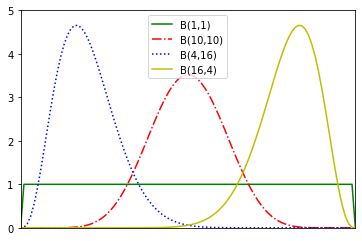

In [71]:
import matplotlib.pyplot as plt

ys_1 = [beta_pdf(num,1,1) for num in xs]
ys_2 = [beta_pdf(num,10,10) for num in xs]
ys_3 = [beta_pdf(num,4,16) for num in xs]
ys_4 = [beta_pdf(num,16,4) for num in xs]
xs = [
    0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,
  0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19,
  0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29,
  0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39,
  0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49,
  0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59,
  0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69,
  0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79,
  0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89,
  0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
  1
]

plt.plot(xs,ys_1,'g-', label="B(1,1)")
plt.plot(xs,ys_2,'r-.', label="B(10,10)")
plt.plot(xs,ys_3,'b:', label="B(4,16)")
plt.plot(xs,ys_4,'y-', label="B(16,4)")
plt.axis([0,1,0,5])

plt.legend(loc=9)
plt.xticks([])

plt.show()

假設我們可以針對p假設一個先驗分佈。  
如果我們對於硬幣是否公正沒有甚麼特別的看法，可以選擇把alpha跟beta的值都設定為1。  
如果我們有強烈地理由相信硬幣有55%的機會擲出正面，  
可以選擇alpha值為55，beta值為45。

## 後驗分佈
後驗分佈亦是Beta分佈。  
正面的次數是二項式分佈所給出的，而Beta分佈正好是二項式分佈的共軛(conjugate)[先驗分佈](http://johndcook.com/blog/conjugate_prior_diagram)

### 圖7-2 從不同的先驗分佈，所得出的後驗分佈

後驗分佈亦是Beta分佈，但兩個參數分別會是 alpha+h 和 beta+h
* 先驗分佈 Beta(20,20) → 後驗分佈 Beta(23,27)
* 先驗分佈 Beta(30,10) → 後驗分佈 Beta(33,17)

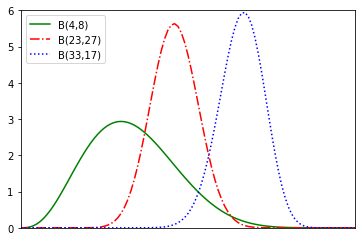

In [75]:
import matplotlib.pyplot as plt

xs = [
    0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,
  0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19,
  0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29,
  0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39,
  0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49,
  0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59,
  0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69,
  0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79,
  0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89,
  0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
  1
]
ys_1 = [beta_pdf(num,4,8) for num in xs]
ys_2 = [beta_pdf(num,23,27) for num in xs]
ys_3 = [beta_pdf(num,33,17) for num in xs]

plt.plot(xs,ys_1,'g-', label="B(4,8)")
plt.plot(xs,ys_2,'r-.', label="B(23,27)")
plt.plot(xs,ys_3,'b:', label="B(33,17)")
plt.axis([0,1,0,6])

plt.legend(loc=2)
plt.xticks([])

plt.show()